# Проект "Предсказание вероятности подключения услуги"

## Постановка задачи

#### Задача

Требуется на основании имеющихся данных об абонентах Мегафон построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

#### Целевая переменная

**target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

*Целевая метрика*

* Метрика оценивается невзвешенным образом, , как например делает функция sklearn.metrics.f1_score(…, average=’macro’)

*Решение должно содержать*

1.	Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2.	Тетрадка Jupyter Notebook с кодом модели. 
3.	Презентация в формате .pdf, в которой необходимо отразить:

   * Информация о модели, ее параметрах, особенностях и основных результатах.
   * Обоснование выбора модели и ее сравнение с альтернативами.
   * Принцип составления индивидуальных предложений для выбранных абонентов.

   Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

## Решение

### 1. Обзор данных

В качестве исходных данных представлена информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных является нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 

Итого, в качестве входных данных представлены:
* **data_train.csv**: 
    * id, 
    * vas_id, 
    * buy_time, 
    * target
* **features.csv.zip**: 
    * id, 
    * ..feature_list..

И тестовый набор:
* **data_test.csv**: 
    * id, 
    * vas_id, 
    * buy_time

**Описание датасета**
* **id** - идентификатор абонента
* **vas_id** - подключаемая услуга
* **buy_time** - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
* **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.

#### Подключение библиотек и скриптов

In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

#### Загрузка данных

Загрузим датасеты, созданные на этапе предподготовки. 

В качестве предподготовки было проведено слияние набора признаков, характеризующих профиль потребления абонента, с тренировочным датасетом, тестовым датасетом. Новые датасеты были сохранены в файлы:
* data_feat_train.pkl - новый тренировчный датасет
* data_feat_test.pkl - новый тестовый датасет

In [2]:
train_path = 'c:/MegafonDS/data_feat_train.pkl'
test_path = 'c:/MegafonDS/data_feat_test.pkl'

In [3]:
train_df = pd.read_pickle(train_path)

#### Получение информации о данных

In [4]:
train_df.shape

(831653, 258)

In [5]:
train_df.head()

,id,vas_id,buy_time_vas,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_delta
0,540968.0,8.0,1.537132e+09,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.512019,33.247475,-36.759495,-7.896282,-7.997875,-10.697456,-28.551693,-17.130283,-16.088985,-26.171711,-5.331295,1.041298,-3.745251,-1.671324,-0.001656,9.318354,15.117334,0.174766,-0.108162,0.028356,-0.017576,-0.165662,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275913,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955315,-1.019293,-1.473446,0.37916,-1006.426575,1242.881104,0.03201,0.196143,236.454514,848.953552,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211945,-119.674408,-208.886353,0.031923,-0.030451,0.104871,1.381836,5.318359,1.426717,-0.468443,-0.017283,-190.670380,5.856777,7.27741,2.174027,5.064012,0.0,-1.276187,-0.020137,-0.042636,-11.480350,-59.370804,34.036369,-17.888325,0.138539,-0.317164,-0.007024,-0.143269,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,1.321786,-0.014542,-0.009508,-8.183167,35.756905,-14.320085,-40.801491,-5.961228,33.187763,-12.614497,-26.671719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793638,-1.932758,-5.008096,-15.978121,-36.800720,-9.354808,-25.320370,-0.034569,-0.163184,-109.036400,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,4838400.0
1,1454121.0,4.0,1.531688e+09,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.5

**Описание датасета**
* **id** - идентификатор абонента
* **vas_id** - подключаемая услуга
* **buy_time_vas** - время покупки
* 253 нормализованных анонимизированных признаков, характеризующих профиль потребления абонента
* **time_delta** - отражает разницу во времени между временными штампами отклика на услугу (buy_time_vas) и фиксации записи по признакам профиля потребления ('buy_time' в наборе признаков, характиризующих профиль потребления абонента)
* **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.

### 2. Анализ признаков

#### target

Целевая переменная, определяет отклик клиента на услугу.

* 0 - клиент отказался от услуги
* 1 - клиент подключил услугу

Рассмотрим распределение переменной в обучающей выборке:

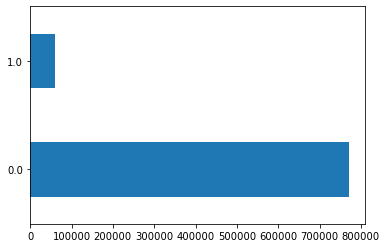

In [6]:
train_df['target'].value_counts().plot(kind='barh')
plt.show()

Наблюдается сильная несбалансированность классов. Это необходимо будет учесть при построении моделей.

#### vas_id

Идентификатор услуги. Рассмотрим распределение признака.

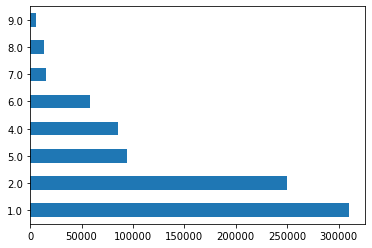

In [7]:
train_df['vas_id'].value_counts().plot(kind='barh')
plt.show()

Будем использовать этот признак в качестве категориального.

#### id

Использование id в модели нецелесообразно. id - уникальный идентификатор клиента: как число исползовать нельзя, а как категорию практически невозможно, так как появляются новые клиенты. Поэтому id не будем использовать в обучающей выборке.

#### buy_time_vas

In [8]:
date = pd.to_datetime(train_df['buy_time_vas'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
date.sample(5)

576577   2018-09-10 00:00:48+03:00
476903   2018-09-10 00:00:48+03:00
50946    2018-12-17 00:00:48+03:00
280160   2018-08-20 00:00:48+03:00
214294   2018-08-06 00:00:48+03:00
Name: buy_time_vas, dtype: datetime64[ns, Europe/Moscow]

Присутствует только информация по дате. Рассмотрим количество уникальных составляющих даты по всему признаку:

In [9]:
date_features = pd.DataFrame()
date_features['month'] = date.dt.month
date_features['day'] = date.dt.day
date_features['dayofyear'] = date.dt.dayofyear
date_features['dayofweek'] = date.dt.dayofweek
date_features['weekofyear'] = date.dt.weekofyear
date_features.nunique()

<ipython-input-9-9fc76aaab98e>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  date_features['weekofyear'] = date.dt.weekofyear


month          6
day           22
dayofyear     26
dayofweek      1
weekofyear    26
dtype: int64

* Имеются наблюдения за 6 месяцев.
* Все наблюдения относятся к одному дню недели, соответственно, данные day, dayofyear не несут никакой полезной информации.
* Признаки month и weekofyear по логике сильно коррелированы.

Рассмотрим влияние номера недели в году на относительную частоту положительного отклика клиентов на услугу.

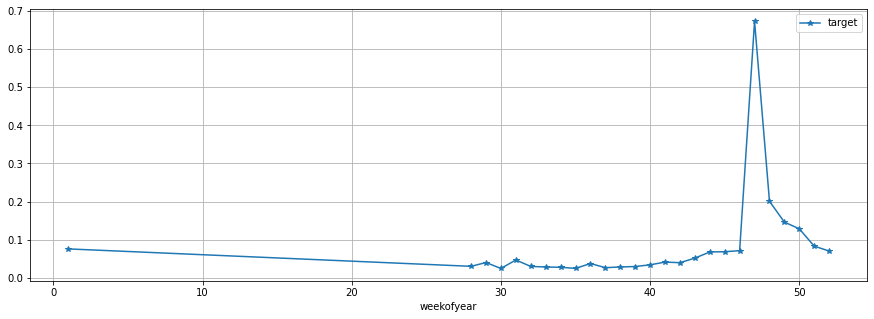

In [10]:
week_target = pd.concat([train_df['target'], date, date_features['weekofyear']], axis=1).sort_values('buy_time_vas')
week_target.groupby('weekofyear').mean().plot(style='-*', figsize=(15,5), grid=True)
plt.show()

Наблюдения weekofyear, имеющие значение 1, на самом деле относятся к самому концу года. Дело в том, что это дата 31 декабря 2018 года. И это понедельник - поэтому алгоритм определяет эту дату как первую неделю 2019 года. Но это не имеет значения.

На графике наблюдается аномальный скачок частоты положительных откликов на 47 неделе. Это 19-25 ноября 2018 г., обычная рабочая неделя. Возможно, данная аномалия может объясняться запуском в этот период особых маркетинговых акций или рекламных кампаний, так как рост скачка резкий, а спад чуть медленнее, инертнее. В любом случае, такие аномалии будут только ухудшать модель, поэтому не будем использовать временные данные buy_time_vas в обучении.

#### time_delta

Значения в секундах. Трансформируем данный признак в диапазоне значений от 0 до 1 и применим экспоненту от отрицательного значения. Чем больше временная разница, тем меньше вес. В конце проверим значения на пропуски.

In [11]:
w_sc = StandardScaler().fit_transform(train_df['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

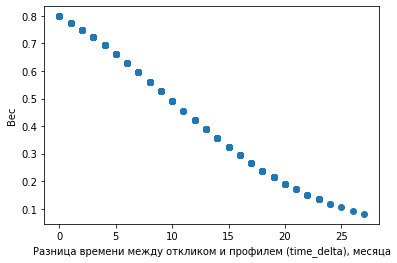

In [12]:
plt.scatter(train_df['time_delta'].values.reshape(-1,1)[:200]/(60*60*24*7),w[:200])
plt.xlabel('Разница времени между откликом и профилем (time_delta), месяца')
plt.ylabel('Вес')
plt.show()

In [13]:
train_df['time_delta'] = w

#### 253 нормализованных анонимизированных признаков, характеризующих профиль потребления абонента

Остальные признаки сложно разведать, поэтому будем применять селекцию признаков.

#### Выделение целевой переменнной

In [14]:
X = train_df.drop(['id','target','buy_time_vas'], axis=1)
y = train_df['target']

### Определение типов признаков

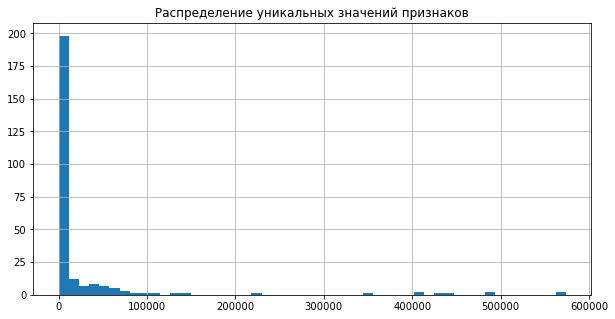

In [15]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=50, figsize=(10, 5));

#### Всего признаков

In [16]:
f_all = set(X_nunique.index.tolist())
len(f_all)

255

#### Константные признаки

In [17]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### Вещественные признаки

In [18]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

248

In [19]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

2

#### Бинарные признаки

In [20]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

In [21]:
f_other = f_other - f_binary
len(f_other)

2

#### Категориальные признаки

Определим максимальное количество уникальных значений среди категориальных признаков = 20

In [22]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 20].index.tolist())
f_categorical

{'vas_id'}

#### Прочие признаки

In [23]:
f_other = f_other - f_categorical
f_other

{'252'}

Рассмотрим признак '252'.

In [24]:
train_df['252'].value_counts()

0.0       620785
1.0       210825
2.0            5
10.0           3
8.0            3
3.0            3
7.0            2
11.0           2
5.0            2
4.0            2
13.0           2
42.0           1
182.0          1
195.0          1
223.0          1
251.0          1
24.0           1
68.0           1
44.0           1
284.0          1
18.0           1
299.0          1
19.0           1
77.0           1
84.0           1
22.0           1
16.0           1
6.0            1
1743.0         1
283.0          1
Name: 252, dtype: int64

Отнесем признак '252' к категориальным

In [25]:
f_categorical = f_categorical | {'252'}
f_other = f_other - {'252'}
len(f_other)

0

Признак time_delta обозначим как весовой тип.

In [26]:
f_weight = {'time_delta'}
f_numeric = (f_numeric | f_other ) - f_weight

Проверка: не осталось ли пропущенных стобцов

In [27]:
assert(X_nunique.shape[0] == len(f_const) + len(f_numeric) + len(f_binary) + len(f_categorical) + len(f_weight))

#### Итог

In [28]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))
print('f_binary:', len(f_binary))
print('f_weight:', len(f_weight))


f_ok = list(f_categorical | f_numeric | f_weight)
f_categorical, f_numeric, f_weight = list(f_categorical), list(f_numeric), list(f_weight)

f_all: 255

f_const: 5
f_categorical: 2
f_numeric: 247
f_binary: 0
f_weight: 1


In [29]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 681
Сколько процент признаков могут принимать null-значениями? 0%


### 3. Логистическая регрессия

#### 3.1 Разделяем на train и test

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

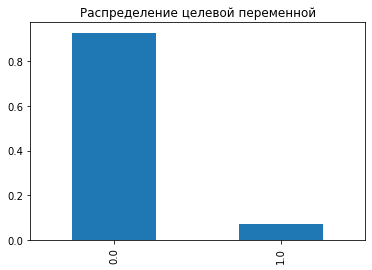

In [30]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [31]:
from sklearn.model_selection import train_test_split

# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 42

train_idx, test_idx = train_test_split(X[f_ok].index, train_size=0.1, test_size=0.033, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.928095
1.0    0.071905
Name: target, dtype: float64

Test
0.0    0.925925
1.0    0.074075
Name: target, dtype: float64


In [32]:
X_train.shape

(83165, 255)

In [33]:
X_test.shape

(27445, 255)

#### 3.2 Pipeline для базовой модели

Для построения baseline модели будем использовать логистическую регрессию.

Логистическая регрессия требует отмасштабированные числовые признаки и перекодированные в числовые категориальные признаки.

Базовый пайплайн будет состоять из трех шагов:

- Масштабирование числовых признаков
- Перекодирование в числовые категориальных признаков
- Логистическая регрессия с базовыми параметрами

In [34]:
from sklearn.linear_model import LogisticRegression

# назовем этот шаг пайплайна log_reg
# параметр n_jobs = сколько процессоров будем использовать.
# -1 означает, что мы будем использовать все процессоры нашего ПК
step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1, max_iter=200))

In [35]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, f_numeric),
    (f_cat_pipepline, f_categorical)
)

In [36]:
# назовем этот шаг пайплайна preproc
step_preproc = ("preproc", preproc_pipeline)

In [37]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_preproc,
    step_log_reg
])

#### 1.4 Кросс-валидация¶

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

* Folds: 1 2 3
    * Train: 1,2 Val: 3
    * Train: 1,3 Val: 2
    * Train: 2,3 Val: 1

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Варианты:
- **‘precision’, ‘recall’, ‘accuracy’, ‘f1’** - используем эти метрики, когда наш алгоритм выдает 0 или 1
- **‘average_precision’, ‘roc_auc’** - используем эти метрики, когда наш алгоритм выдает значения от 0 до 1. Это веротяность того, чт объект принадлежит классу 1.

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# класс KFolf разделит выборку на три фолда, перед разделение премешает данные, так как мы выставили shuffle=True
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    """
    Процедура вычисляет кросс-валидацию и выводит её на экрнан
    Метод cross_validate делает расчет метрики на кросс-валидации. Он разбивает выборку на фолды,
    на каждом фитит модель и предиктит на валидационном датасете.
    По всем фолдам усредняет значение метрики.
    """
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

Посмотрим на значение метрики на кросс-валидации, оно понадобится для сравнения с последующими моделями.

In [39]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.84 (+/- 0.01)


In [40]:
%%time

# фитим пайплайн на трейновом множестве 
bl_estimator.fit(X_train, y_train)

# предиктим пайпланй на тестовом множестве. Лог.регрессия имеет значения от 0 до 1.
bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

Wall time: 1min 37s


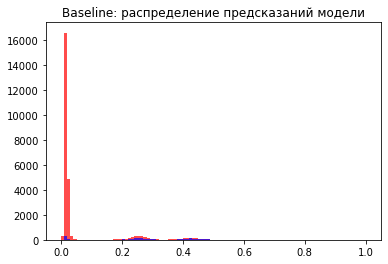

In [41]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

#### Roc и PR Кривые

In [42]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.844


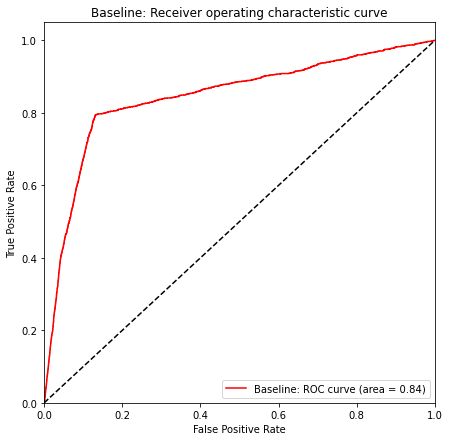

In [43]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.344


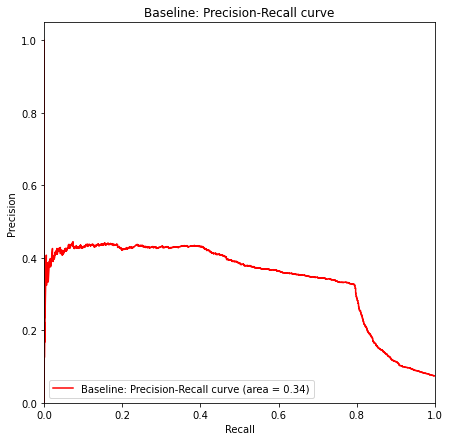

In [44]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

**Далее рассмотрим метрики, когда наш классфикатор говорит 0 или 1**

Эти метрики строятся на матрице смежности.

0 - абонент не подключил услугу

1 - абонент подключил услугу

#### Матрица смежности

In [45]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[25356    56]
 [ 1998    35]]


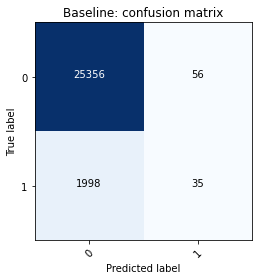

In [46]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [47]:
from sklearn.metrics import classification_report

# выбирем порог 0.5
print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.38      0.02      0.03      2033

    accuracy                           0.93     27445
   macro avg       0.66      0.51      0.50     27445
weighted avg       0.89      0.93      0.89     27445



In [48]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp) # эквивалентно accuracy
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2 # берем среднее от precision по обоим классам

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.93
           1 precision = 0.38
              1 recall = 0.02
   micro avg precision = 0.93 
   macro avg precision = 0.66 
weighted avg precision = 0.89 


## 3 sklearn.Pipeline

### 3.1 Column Selector

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

In [50]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

### 3.2 Пайплайн обработки признаков

In [51]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [52]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [53]:
X_test.shape[1]

255

In [54]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

260

### 3.3 Gridsearch для пайплайнов

In [55]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    
    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

Про поиск имен параметров

In [58]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

Сравним с baseline моделью, у которой roc_auc = 0.84 (+/- 0.01)

In [59]:
param_grid = {
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__C": [0.01, 0.1, 5.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.84

Best parameters set found on development set:

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.837 (+/-0.006) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.837 (+/-0.005) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l1'}
0.838 (+/-0.005) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}



C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
lg_gsc.best_params_

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

#### остановимся на том, что коэф С=5.0, регуляризация l2

### 3.4 Отбор признаков в пайплайнах

In [61]:
from sklearn.feature_selection import SelectFromModel

Атрибут estimator класса SelectFromModel должен иметь хотя бы один из атрибутов feature_importances_ или coef_ после выполнения метода fit.

In [62]:
#  Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
# по атрибуту threshold будет отрезаться признак, если он меньше заданного значения этого атрибута
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
)

In [63]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(27445, 260)

In [64]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(27445, 257)

In [65]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [66]:
# исследуем при разных количествах призаков, независимо от threshold
param_grid = [
    {"selectfrommodel__max_features": [None, 5, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
    {"selectfrommodel__threshold": [1e-5]},
]

lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best roc_auc score: 0.84

Best parameters set found on development set:

{'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.838 (+/-0.005) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.009) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.842 (+/-0.012) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.841 (+/-0.009) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.841 (+/-0.006) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.839 (+/-0.005) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.838 (+/-0.005) for {'selectfrommodel__threshold': 1e-05}



Вывод: при количестве признаков 5, 10 roc_auc незначительно отличается от максимального значения. Если возьмем 10 признаков, то сэкономим 250 признаков и не потеряем нашей метрики.

## 4 Финальная модель

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

In [68]:
# создадим пайплайн с отбром признаков через лог.регрессию с регуляризаией l2, в конце эстимейтром  GradientBoostingClassifier
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
    GradientBoostingClassifier()
)

In [69]:
[k for k in gb_fs_pipe.get_params().keys() if 'grad' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_impurity_split',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__presort',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingcla

In [70]:
param_grid = {
    "selectfrommodel__threshold": [-np.inf, 1e-05],
    
    "gradientboostingclassifier__max_depth": [1, 5],
    "gradientboostingclassifier__n_estimators": [10, 100]
}

gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best roc_auc score: 0.84

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.833 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.833 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}
0.840 (+/-0.010) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.010) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}
0.841 (+/-0.013) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.841 (+/-

### 4.1 Сравнение моделей

In [71]:
# модель бейзлайн
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

# модель с предобработкой признаков и лог.регрессией с отбором признаков
lg_fs_pipe_final.fit(X_train, y_train)

# модель с предобработкой признаков, лог.регрессией с отбором признаков и градиентным бустингом
lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:,1]

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.00      0.00      0.00      2033

    accuracy                           0.93     27445
   macro avg       0.46      0.50      0.48     27445
weighted avg       0.86      0.93      0.89     27445



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
gb_fs_pipe_final = gb_fs_gsc.best_estimator_

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_test)[:,1]

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
print(classification_report(y_test, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.50      0.00      0.00      2033

    accuracy                           0.93     27445
   macro avg       0.71      0.50      0.48     27445
weighted avg       0.89      0.93      0.89     27445



Вывод: модель с градиентым бустингом дает выше значения precision (0.93=0.93), recall (1=1) и f1-score(0.96=0.96). То есть с точки зрения бизнеса она не лучше.

Baseline: AUC_PR = 0.344
Baseline: AUC_ROC = 0.844
lg_fs_pred: AUC_PR = 0.439
lg_fs_pred: AUC_ROC = 0.842
gb_fs_pred: AUC_PR = 0.358
gb_fs_pred: AUC_ROC = 0.846


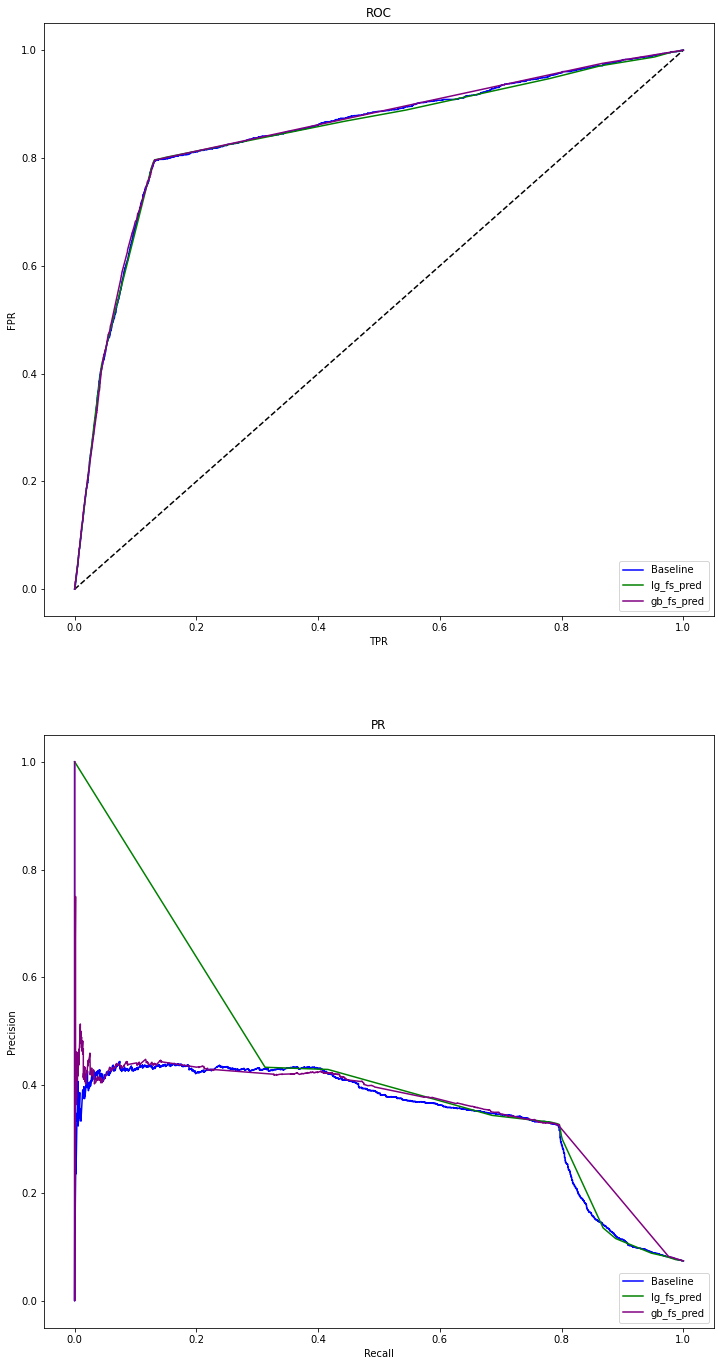

In [75]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label="lg_fs_pred", color='g')
ax2.plot(recall, precision, label="lg_fs_pred", color='g')
print("lg_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lg_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, gb_fs_pred)
ax1.plot(fpr, tpr, label="gb_fs_pred", color='purple')
ax2.plot(recall, precision, label="gb_fs_pred", color='purple')
print("gb_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("gb_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");